In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [3]:
cool_sgs = pd.read_csv('sample.csv',index_col=0)
pulse = pd.read_csv('prewhitening.csv',index_col=0)
merged = pd.merge(cool_sgs,pulse,left_index=True,right_index=True)

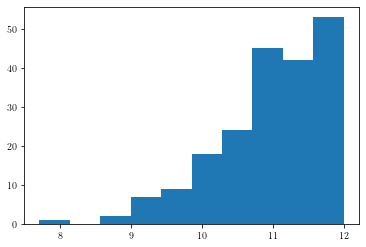

In [4]:
plt.hist(merged['Tmag']);

Ok, so we observe a star with magnitude $T$ that varies with amplitude $Y$. But it's actually contaminated by a star that's a flux ratio $R$ times fainter than the main star, corresponding to a magnitude difference of 

$\Delta T = -2.5 \log R$,

pulsating with an actual amplitude of $X$. 

The intrinsic and observed amplitudes are related by a factor of $R$:

$Y = R X$.

So if we observe $Y$, this corresponds to a star of magnitude $T+\Delta T$ pulsating with an amplitude of $-2.5\log(1+Y/R)$ 

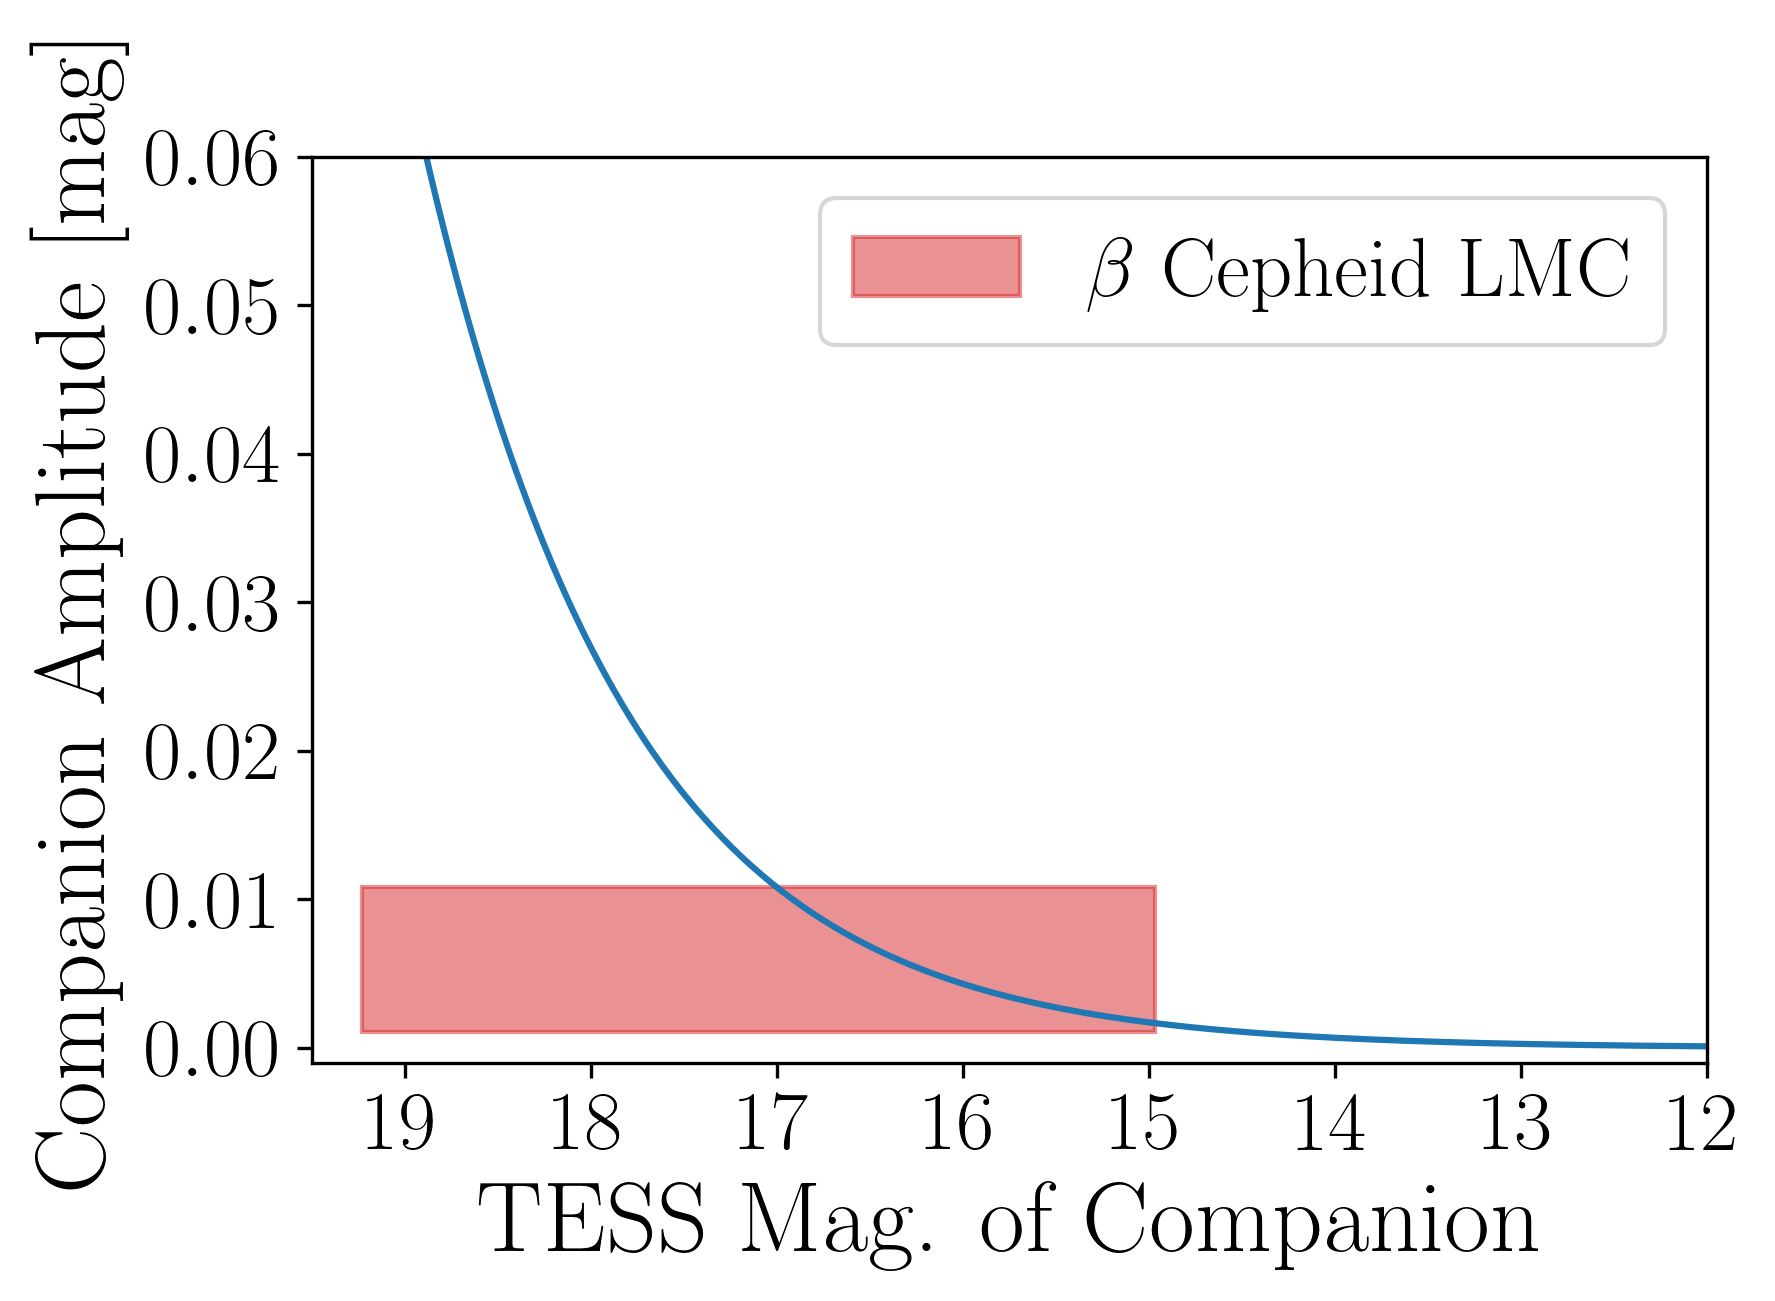

In [5]:
from matplotlib.patches import Rectangle

observed = 0.0001
T0 = 12

T1s = np.linspace(T0,20,300)
dTs = T1s-T0

R = np.power(10.0,-dTs/2.5)
real = 2.5*np.log10(1.0 + observed/R)

B_lmc = [14.97,19.23]
B_smc = [15.31,19.61]
B_amps = [2.5*np.log10(1+0.001),2.5*np.log10(1+0.01)]


fig = plt.figure(dpi=300)

plt.plot(T1s,real)

B_lmc_rect = Rectangle([B_lmc[0],B_amps[0]],B_lmc[1]-B_lmc[0],B_amps[1]-B_amps[0],color='C3',alpha=0.5,label=r'$\beta$ Cepheid LMC')
plt.gca().add_patch(B_lmc_rect)

"""B_smc_rect = Rectangle([B_smc[0],B_amps[0]],B_smc[1]-B_smc[0],B_amps[1]-B_amps[0],color='C4',alpha=0.5,label=r'$\beta$ Cepheid SMC')
plt.gca().add_patch(B_smc_rect)

"""

plt.xlabel('TESS Mag. of Companion',fontsize=24)
plt.ylabel('Companion Amplitude [mag]',fontsize=24)
plt.xlim(19.5,12)
plt.ylim(-0.001,0.06)

for tick in plt.gca().xaxis.get_major_ticks():
    tick.label.set_fontsize(20)
for tick in plt.gca().yaxis.get_major_ticks():
    tick.label.set_fontsize(20)
    
plt.legend(fontsize=20)
    
plt.savefig('../plots/bcep_contaminant.pdf',bbox_inches='tight')

So we can see that for this made-up star (12th mag, 100 ppm amplitude), it's likely to be a $\beta$ Cepheid!

In [6]:
# Now let's automatically do it for every star
from tqdm.notebook import tqdm

tics = []
likely_bcep = []

for tic,star in tqdm(merged.iterrows(), total=len(merged)):
    
    tics.append(tic)
    
    if star['highest_amp'] > 0:

        T0 = star['Tmag']
        observed = star['highest_amp']

        T1s = np.linspace(T0-1,20,300)
        dTs = T1s-T0

        R = np.power(10.0,-dTs/2.5)
        real = 2.5*np.log10(1.0 + observed/R)
        
        if star['Gal'] == 'LMC':
            mag_lim = B_lmc
        elif star['Gal'] == 'SMC':
            mag_lim = B_smc
        else:
            print('something is wrong')
            
        in_box = ((T1s >= mag_lim[0]) &
                  (T1s <= mag_lim[1]) & 
                  (real >= B_amps[0]) &
                  (real <= B_amps[1]))
        
        likely_bcep.append(np.any(in_box))
    else:
        likely_bcep.append(False)

bcep_df = pd.DataFrame(likely_bcep,columns=['LikelyBCep'],index=tics)

  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/201 [00:00<?, ?it/s]

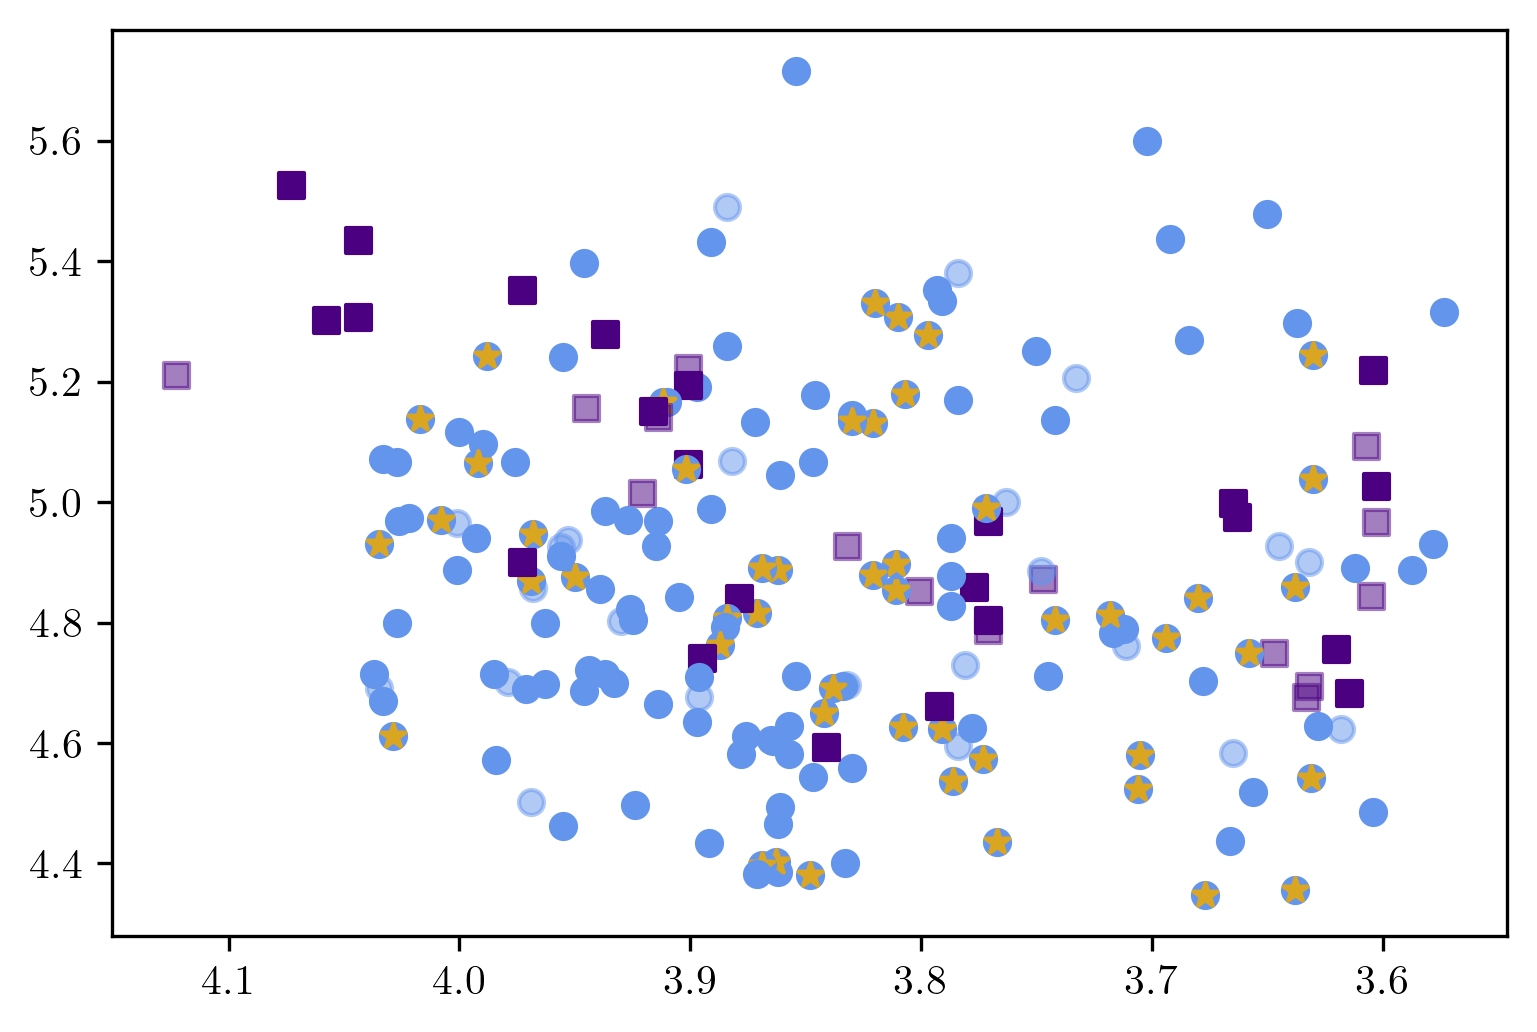

In [7]:
fig = plt.figure(dpi=300)
for tic,star in tqdm(merged.iterrows(), total=len(merged)):
    if star['Gal'] == 'LMC':
        m = 'o'
        c = 'cornflowerblue'
    else:
        m = 's'
        c = 'indigo'
        
    if star['highest_amp'] > 0:
        alpha = 1.0
    else:
        alpha = 0.5
        
    plt.scatter(star['teff'],star['lum'],marker=m,c=c,alpha=alpha)
    
    if bcep_df.loc[tic]['LikelyBCep']:
        plt.scatter(star['teff'],star['lum'],marker='*',c='goldenrod')
        
plt.gca().invert_xaxis()

In [10]:
len(bcep_df[bcep_df['LikelyBCep']])

49

In [7]:
bcep_df.to_csv('likelyBCep.csv')